# Datasets comparison between CAMS and IASI (L2)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (CO, O3 or SO2)
component_nom = 'CO'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'iasi'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2020-02-01'
end_date = '2020-02-01'
"""
# Define extent
area_name = 'Global'
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 90
"""
# Define extent
area_name = 'Asia'
lon_min = 110
lon_max = 135
lat_min = 30
lat_max = 45

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_MW, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: ('2020-02-01',)
SEARCH BOUNDING BOX
Latitudes: from 30 to 45
Longitudes: from 110 to 135


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'single', CAMS_UID = None, CAMS_key = None)

2022-01-30 11:06:04,449 INFO Welcome to the CDS
2022-01-30 11:06:04,453 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts


The file does not exist, it will be downloaded.


2022-01-30 11:06:04,538 INFO Request is completed
2022-01-30 11:06:04,542 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data6/adaptor.mars_constrained.external-1643494880.6687298-15925-15-f399ee7d-db32-4bd8-8199-e96a8b68f720.grib to /home/alba/adc-toolbox/data/cams/CO/CAMS_FORECAST_CO_TC_2020-02-01_2020-02-01_Asia.grib (57K)
2022-01-30 11:06:04,657 INFO Download rate 499.4K/s


In [8]:
model_ds, dates, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 38, longitude: 63, step: 8, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2020-02-01
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 30.0 30.4 30.8 31.2 ... 43.6 44.0 44.4 44.8
  * longitude   (longitude) float64 110.0 110.4 110.8 ... 134.0 134.4 134.8
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 0.001347 ... 0.0008058
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-30T11:06 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Get CAMS levels (total or tropospheric)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_MW, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


### Convert CAMS data units

In [11]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

The model total columns will be compared to the total sensor columns.


<xarray.Dataset>
Dimensions:     (latitude: 38, longitude: 63, step: 8, time: 1)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2020-02-01
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 30.0 30.4 30.8 31.2 ... 43.6 44.0 44.4 44.8
  * longitude   (longitude) float64 110.0 110.4 110.8 ... 134.0 134.4 134.8
    valid_time  (step) datetime64[ns] 2020-02-01 ... 2020-02-01T21:00:00
Data variables:
    component   (time, step, latitude, longitude) float32 2.896e+18 ... 1.733...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-30T11:06 GRIB to CDM+CF via cfgrib-0.9.9...

## 3. Sensor data

### Download and read data as xarray

In [12]:
dates = sensor_download(sensor, sensor_type, component_nom, dates)

RESULTS
For 2020-02-01:
IASI_METOPA_L2_CO_20200201_ULB-LATMOS_V6.5.0.nc was downloaded.
IASI_METOPB_L2_CO_20200201_ULB-LATMOS_V6.5.0.nc was downloaded.
IASI_METOPC_L2_CO_20200201_ULB-LATMOS_V6.5.0.nc was downloaded.


In [13]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

/tmp/ipykernel_2669703/1362158709.py:86: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.DataArray 'sensor_column' (time: 1, latitude: 180, longitude: 360)>
array([[[0.02426029, 0.024177  , 0.0233791 , ..., 0.02614328,
         0.02574695,        nan],
        [0.0291054 , 0.02650232, 0.02995933, ..., 0.02811868,
         0.02861892,        nan],
        [0.01848878, 0.01850079, 0.01918354, ..., 0.01987049,
         0.02048329,        nan],
        ...,
        [0.02357248, 0.0255702 , 0.0259032 , ..., 0.02480064,
         0.02576851,        nan],
        [0.02805027,        nan, 0.03028313, ..., 0.02423287,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  datetime64[ns] 2020-02-01
  * time        (time) datetime64[ns] 2020-02-01
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [14]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component_nom)
sensor_ds

The sensor component units have been converted from mol m-2 to molec cm-2.


<xarray.DataArray 'sensor_column' (time: 1, latitude: 180, longitude: 360)>
array([[[1.46098860e+18, 1.45597278e+18, 1.40792209e+18, ...,
         1.57438522e+18, 1.55051714e+18,            nan],
        [1.75276778e+18, 1.59600696e+18, 1.80419294e+18, ...,
         1.69334617e+18, 1.72347144e+18,            nan],
        [1.11342032e+18, 1.11414328e+18, 1.15525957e+18, ...,
         1.19662878e+18, 1.23353227e+18,            nan],
        ...,
        [1.41956749e+18, 1.53987310e+18, 1.55992720e+18, ...,
         1.49352918e+18, 1.55181556e+18,            nan],
        [1.68922641e+18,            nan, 1.82369242e+18, ...,
         1.45933758e+18,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]])
Coordinates:
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    delta_time  datetime64[ns] 2020-02-01
  * time        (time) datetime64[ns] 2020-02-01
Attributes:
    units:    molec cm-2

## 4. Match data

In [15]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR DATE: 2020-02-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.


,latitude,longitude,delta_time,time,sensor_column,step_index,model_column
0,29.5,109.5,2020-02-01,2020-02-01,NaN,0,2.895712e+18
1,29.5,110.5,2020-02-01,2020-02-01,NaN,0,2.926959e+18
2,29.5,111.5,2020-02-01,2020-02-01,4.003890e+18,0,3.968372e+18
3,29.5,112.5,2020-02-01,2020-02-01,3.273320e+18,0,4.214759e+18
4,29.5,113.5,2020-02-01,2020-02-01,2.929941e+18,0,4.200092e+18
...,...,...,...,...,...,...,...
411,44.5,130.5,2020-02-01,2020-02-01,1.665525e+18,0,1.871950e+18
412,44.5,131.5,2020-02-01,2020-02-01,1.553249e+18,0,1.772683e+18
413,44.5,132.5,2020-02-01,2020-02-01,1.726649e+18,0,1.826557e+18
414,44.5,133.5,2020-02-01,2020-02-01,1.764015e+18,0,1.786769e+18


## 5. Merge data and calculate difference

In [16]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
29.5     109.5     2020-02-01  2.895712e+18            NaN           NaN   
         110.5     2020-02-01  2.926959e+18            NaN           NaN   
         111.5     2020-02-01  3.968372e+18   4.003890e+18 -3.551772e+16   
         112.5     2020-02-01  4.214759e+18   3.273320e+18  9.414384e+17   
         113.5     2020-02-01  4.200092e+18   2.929941e+18  1.270151e+18   
...                                     ...            ...           ...   
44.5     130.5     2020-02-01  1.871950e+18   1.665525e+18  2.064246e+17   
         131.5     2020-02-01  1.772683e+18   1.553249e+18  2.194346e+17   
         132.5     2020-02-01  1.826557e+18   1.726649e+18  9.990804e+16   
         133.5     2020-02-01  1.786769e+18   1.764015e+18  2.275382e+16   
         134.5     2020-02-01  1.766558e+18   1.796754e+18 -3.019548e+16   

                               relative_difference  
latitude longitude time                             
29.5     109.5     2020-02-01                  NaN  
         110.5     2020-02-01                  NaN  
         111.5     2020-02-01            -0.008871  
         112.5     2020-02-01             0.287610  
         113.5     2020-02-01             0.433507  
...                                            ...  
44.5     130.5     2020-02-01             0.123940  
         131.5     2020-02-01             0.141275  
         132.5     2020-02-01             0.057862  
         133.5     2020-02-01             0.012899  
         134.5     2020-02-01            -0.016806  

[416 rows x 4 columns]

In [17]:
descr_stats_table = merge_df.describe()
descr_stats_table

,model_column,sensor_column,difference,relative_difference
count,4.160000e+02,4.060000e+02,4.060000e+02,406.000000
mean,2.501781e+18,2.316503e+18,1.704205e+17,0.069540
std,8.220988e+17,5.629447e+17,5.191168e+17,0.202334
min,1.328358e+18,1.221350e+18,-1.181936e+18,-0.322603
25%,1.921252e+18,1.811077e+18,-1.508957e+17,-0.070411
50%,2.195477e+18,2.271134e+18,5.001495e+16,0.025423
75%,3.014831e+18,2.710987e+18,4.352479e+17,0.171600
max,5.351103e+18,4.286582e+18,2.153078e+18,0.769820


## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2020-02-01']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((110, 30), (135, 45))


### Compare CAMS and IASI total columns

Frame length between 110 and 135 should be one of these options: [1, 5, 25]
Frame length between 30 and 45 should be one of these options: [1, 3, 5, 15]


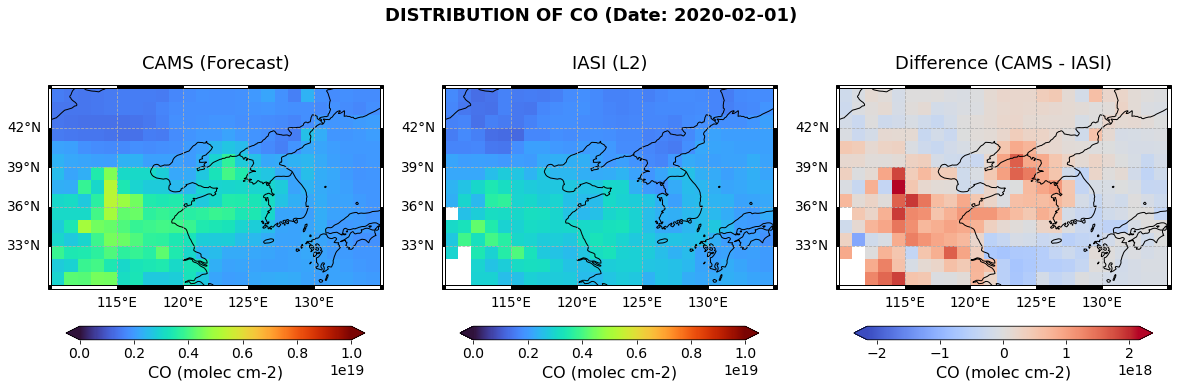

In [20]:
# Choose distribution (aggregated, individual or animated)
plot_type = 'individual'

# Define range (original, equal, centered or manual)
range_type = 'manual'
vmin_manual, vmax_manual = 0, 1*10**19
vmin_manual_diff, vmax_manual_diff = None, None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 5
height_lat = 3

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, plot_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual,
                          vmin_manual_diff, vmax_manual_diff,
                          bbox_list = None, coords_list = None, regions_names = None)

## 7. Retrieve nearest values to specific coordinates

In [21]:
regions_names = ('Prague', 'Seoul', 'Lagos')
coords_list = (50.07, 14.43,
               37.54, 126.95,
               6.45, 3.38)
ymin = 0
ymax = 0.5*10**19
xticks = plot_dates

timeseries_table = timeseries(merge_df, component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

,,,,,,model_column,sensor_column,difference,relative_difference
region,lat_search,lon_search,latitude,longitude,time,,,,
Prague,50.07,14.43,44.5,109.5,2020-02-01,1.554810e+18,1.500351e+18,5.445865e+16,0.036297
Seoul,37.54,126.95,37.5,126.5,2020-02-01,2.991355e+18,1.906956e+18,1.084399e+18,0.568654
Lagos,6.45,3.38,31.5,109.5,2020-02-01,2.938934e+18,2.425194e+18,5.137402e+17,0.211835


## 8. Scatter plots by bbox

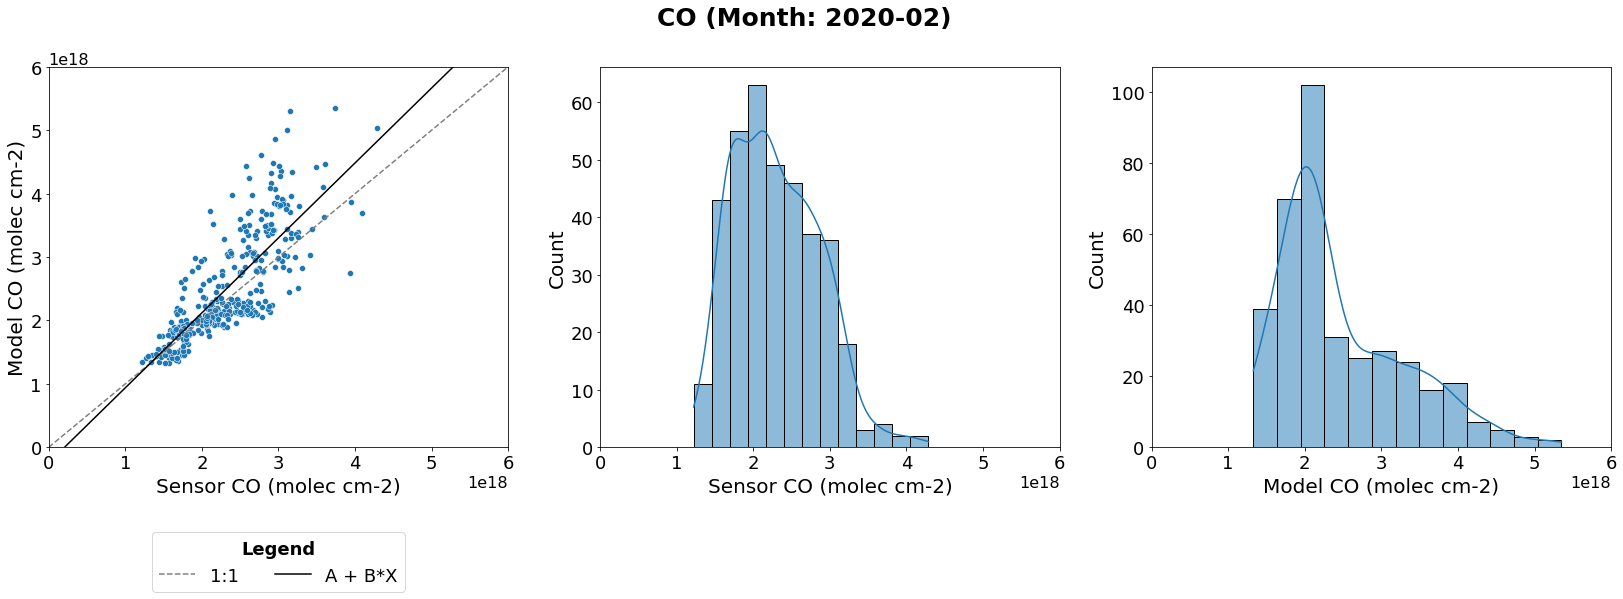

,Period,Location,A,B,R2,RMSE,MSE
0,2020-02-01,"((110, 30), (135, 45))",1.181902,-2.439761e+17,0.638828,4.967571e+17,2.467676e+35


In [22]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = 0
lim_max = 0.6*10**19

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 9. Scatter plots by season

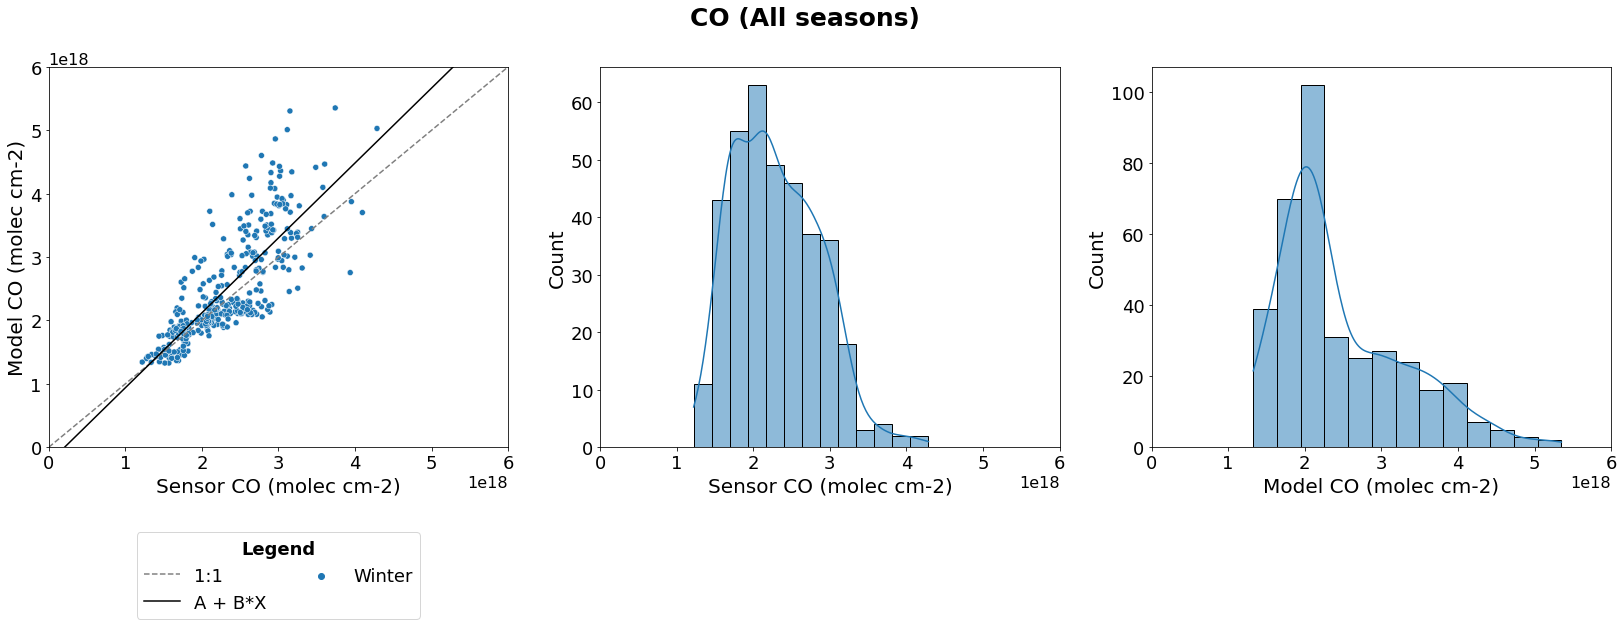

,Period,Location,A,B,R2,RMSE,MSE
0,[Winter],"((110, 30), (135, 45))",1.181902,-2.439761e+17,0.638828,4.967571e+17,2.467676e+35


In [23]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 0
lim_max = 0.6*10**19

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 10. Scatter plots by country (Google API required!)

In [24]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['China', 'South Korea']

lim_min = 0
lim_max = 0.6*10**19

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['China', 'South Korea']\n\nlim_min = 0\nlim_max = 0.6*10**19\n\nsummary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, \n                       lim_min, lim_max, plot_countries)\nsummary\n"